In [1]:
import GetOldTweets3 as got
import pandas as pd
from functools import reduce
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import nltk
import re
import numpy as np
%matplotlib inline

## 0. Scrap 200 twitters per day related to Covid19 

In [19]:
def text_query_to_csv(text_query, count, since_date,until_date):
    # Creation of query object
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
        .setMaxTweets(count).setLang('en')\
        .setSince(since_date).setUntil(until_date)
    # Creation of list that contains all tweets
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)

    # Creating list of chosen tweet data
    text_tweets = [[tweet.date, tweet.text] for tweet in tweets]
    
    # Creation of dataframe from tweets
    return text_tweets
    # Converting tweets dataframe to csv file

In [3]:
from datetime import date
def twitter_to_csv(text_query, count, year, startmonth, endmonth):
    months = np.arange(startmonth,endmonth+1)
    text_tweets = []
    for month in months:
        days = (date(year, month+1, 1) - date(year, month, 1)).days
        for day in range(days):
            since_date = pd.datetime(year,month,day+1).strftime('%Y-%m-%d')
            until_date = (pd.datetime(year,month,day+1)+pd.Timedelta(days=1)\
                         ).strftime('%Y-%m-%d')
            text_tweets += text_query_to_csv(text_query, count, since_date,until_date)
    tweets_df = pd.DataFrame(text_tweets, columns = ['Datetime', 'Text'],\
            index = range(len(text_tweets)))
    tweets_df.to_csv('{}-{}k-{}tweets.csv'.format(text_query,\
                                int(count/1000), year), sep=',')
    

In [ ]:
text_query = 'COVID19'
count = 100
twitter_to_csv(text_query, count,2020,2,7)

# 1. find out most frequent words 

In [2]:
def add_up_words(f):
    def add_up(a,b):
        return a+b
    return reduce(add_up,[f.Text[i] for i in f.index])

In [3]:
def tokens_clean(tokens):
    # remove urls 
    tokens = re.sub(r"http\S+", ' ', tokens)
    # remove symbols 
    tokens = re.sub(r'[^\w]', ' ', tokens)
    # remove numbers
    tokens = re.sub(r'\d', '', tokens)
    tokens = tokens.split()

    # clean stopwords
    from nltk.corpus import stopwords
    sr= stopwords.words('english')
    
    # of course we should avoid words like covid19, coronavirus
    sr += ['covid19','covid','coronavirus','covid-19','pandemic','amp',\
          'corona','virus','via']
    clean_tokens = tokens[:]
    for token in tokens:
        if token in sr:  
            clean_tokens.remove(token)
    return clean_tokens

In [4]:
def plot_frequency(clean_tokens,num):
    #plt.figure(figsize=[10,6])
    freq = nltk.FreqDist(clean_tokens)
    #for key,val in freq.items():
    #     print(str(key) + ':' + str(val)
    freq.plot(10, cumulative=False)
    return freq.most_common(num)

In [5]:
def plot_word_cloud(all_texts,ax):
    # all_texts must be a string 
    covid_wc = WordCloud(
        background_color='white',
        max_words=100
        )

    # generate the word cloud
    covid_wc.generate(all_texts)

    # display the word cloud
    ax.imshow(covid_wc, interpolation='bilinear')
    ax.axis('off')


In [6]:
f1 = pd.read_csv('COVID19-0k-2020tweets.csv',index_col=[0],parse_dates=[1])
f2 = pd.read_csv('coronavirus-0k-2020tweets.csv',index_col=[0],parse_dates=[1])
f = pd.concat([f1,f2], ignore_index=True)


In [7]:
clean_tokens = []
for i in range(6):
    tokens = add_up_words(f.loc[f.Datetime.dt.month==i+2]).lower()
    clean_tokens += [tokens_clean(tokens)]

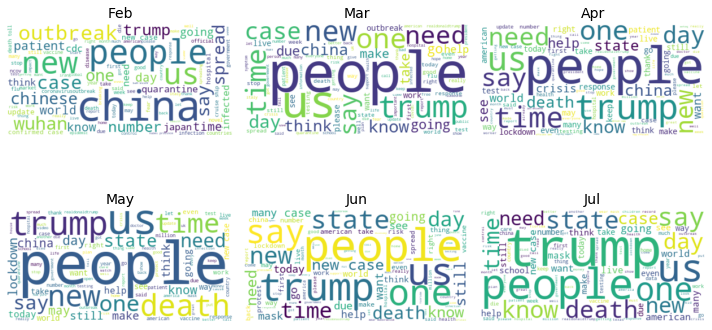

In [9]:
fig,axs = plt.subplots(2,3,figsize=[10,6])
axs = axs.flatten()
titles = ['Feb','Mar','Apr','May','Jun','Jul']
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    plot_word_cloud(all_texts,axs[i])
    axs[i].set_title(titles[i],fontsize=14)
plt.tight_layout()
#plt.savefig('/sn2/wyu/research/temporary/monthly_keywords.pdf')

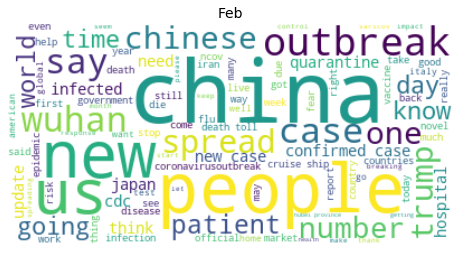

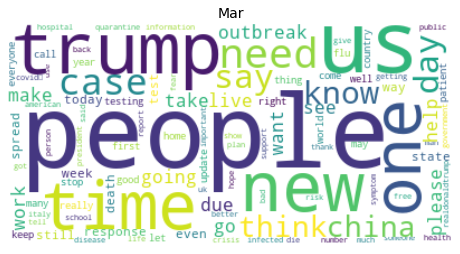

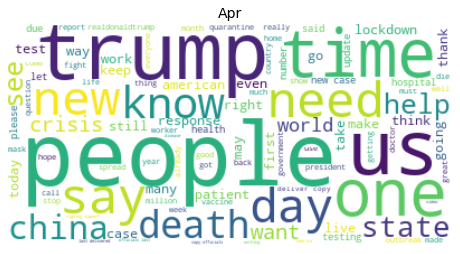

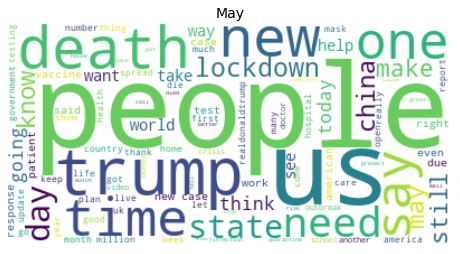

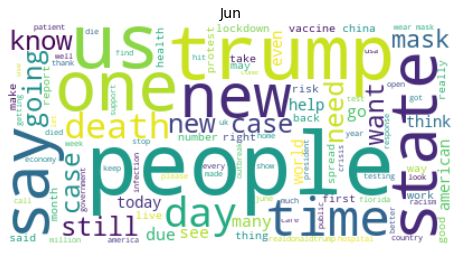

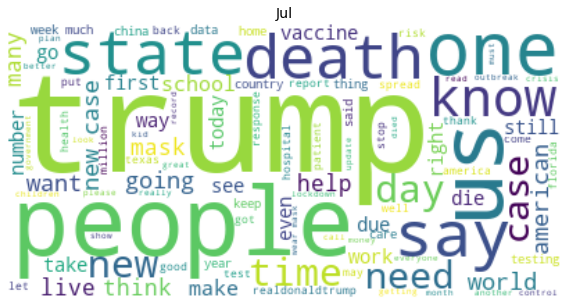

In [12]:
titles = ['Feb','Mar','Apr','May','Jun','Jul']
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    fig = plt.figure(figsize=[8,5])
    plot_word_cloud(all_texts,fig.gca())
    fig.gca().set_title(titles[i],fontsize=14)
plt.tight_layout()

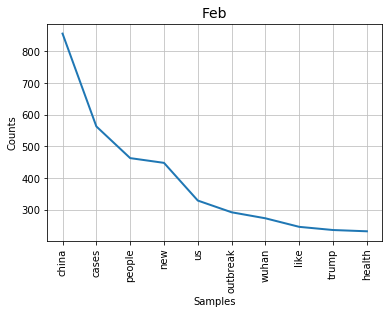

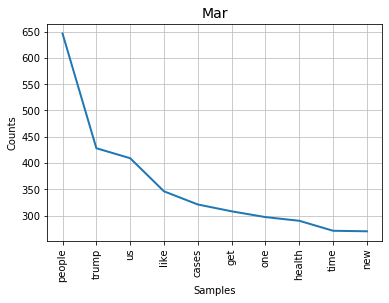

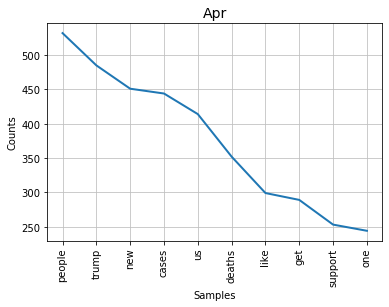

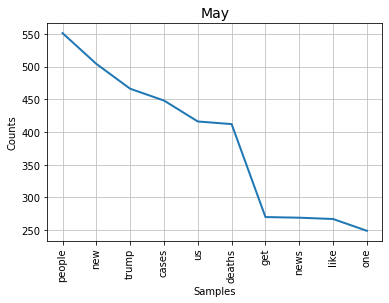

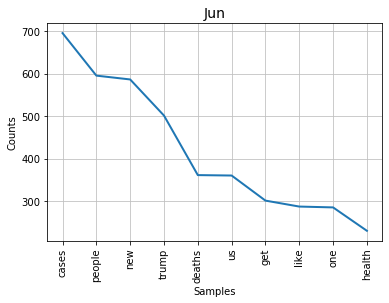

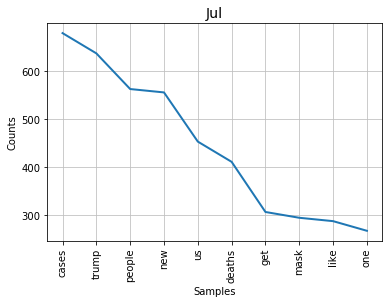

<Figure size 432x288 with 0 Axes>

In [18]:
titles = ['Feb','Mar','Apr','May','Jun','Jul']
most_common_months = []
for i in range(6):
    all_texts = ' '.join(clean_tokens[i])
    plt.title(titles[i],fontsize=14) 
    most_common_months += [plot_frequency(clean_tokens[i],100)]  
plt.tight_layout()


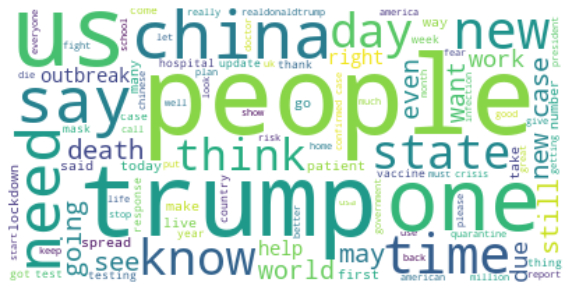

In [14]:
clean_tokens_all = reduce(lambda x,y: x+y, clean_tokens)
fig = plt.figure(figsize=[10,6])
plot_word_cloud(' '.join(clean_tokens_all),fig.gca())

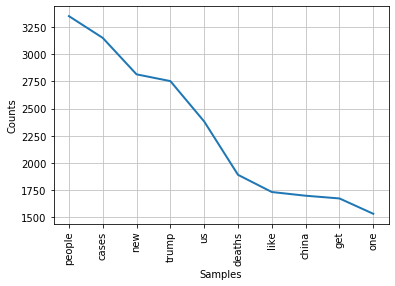

In [15]:
# find out most frequent words 
most_common = plot_frequency(clean_tokens_all,60)  

In [16]:
from collections import defaultdict
words_frequency = defaultdict(list)

In [19]:
words = [x[0] for x in most_common]
for word in words:
    for frequencys in most_common_months:
        flag = 0
        for frequency in frequencys:
            if frequency[0] == word:
                words_frequency[word].append(frequency[1]/200)
                flag = 1
                break
        if flag == 0:
            words_frequency[word].append(0)

In [20]:
words_frequency

defaultdict(list,
            {'people': [2.315, 3.23, 2.66, 2.755, 2.975, 2.81],
             'cases': [2.815, 1.605, 2.22, 2.24, 3.475, 3.39],
             'new': [2.24, 1.35, 2.255, 2.52, 2.93, 2.775],
             'trump': [1.18, 2.14, 2.425, 2.33, 2.505, 3.18],
             'us': [1.645, 2.045, 2.07, 2.08, 1.8, 2.265],
             'deaths': [1.085, 0.69, 1.76, 2.06, 1.805, 2.055],
             'like': [1.23, 1.73, 1.495, 1.335, 1.435, 1.44],
             'china': [4.28, 0.92, 1.065, 0.98, 0.63, 0.62],
             'get': [0.995, 1.54, 1.445, 1.35, 1.505, 1.535],
             'one': [0.95, 1.485, 1.22, 1.245, 1.425, 1.34],
             'health': [1.16, 1.45, 1.13, 1.2, 1.15, 1.165],
             'news': [1.055, 0.975, 0.945, 1.345, 1.11, 1.325],
             'time': [0.6, 1.355, 1.145, 1.15, 1.035, 1.095],
             'world': [1.07, 0.905, 1.03, 1.125, 1.06, 1.005],
             'know': [0.76, 1.08, 1.125, 0.905, 0.865, 0.985],
             'would': [0.705, 1.065, 1.0, 0.925, 0.

In [21]:
important_keywords = ['cases','trump','us','deaths','china','mask'\
        ,'positive','public','spread']

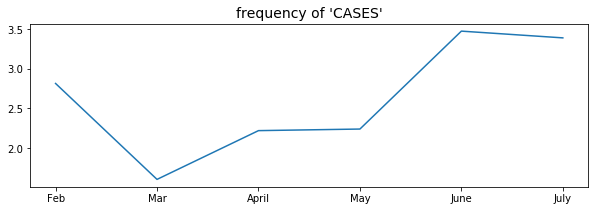

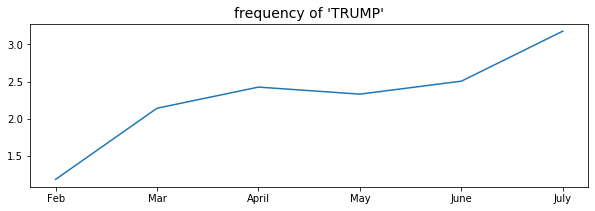

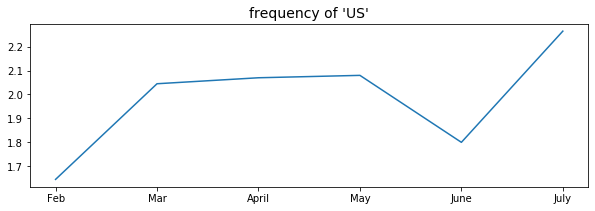

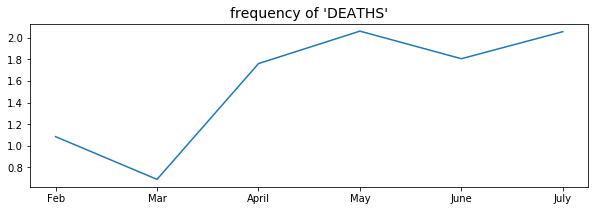

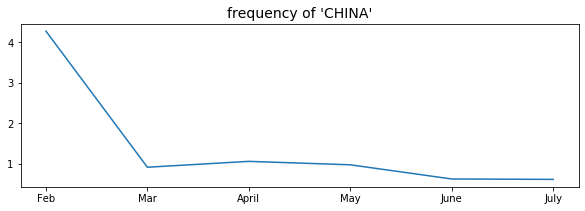

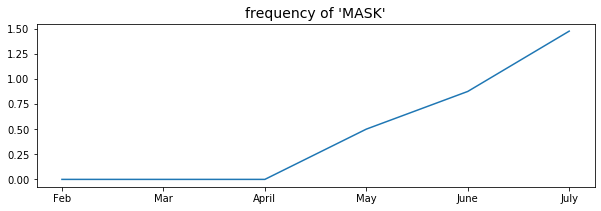

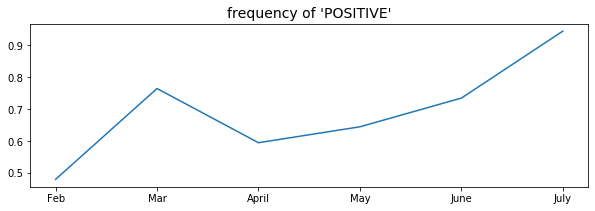

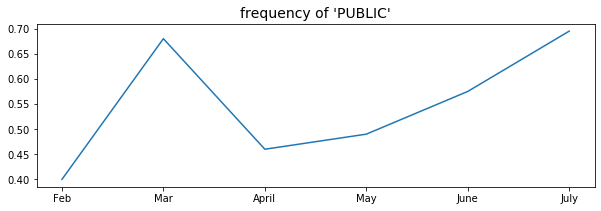

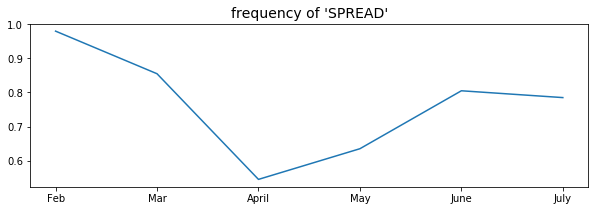

In [26]:
for keywords in important_keywords:
    plt.figure(figsize=[10,3])
    plt.plot(words_frequency[keywords])
    plt.title('frequency of \''+ keywords.upper()+'\'', fontsize=14)
    plt.xticks(range(6),['Feb','Mar','April',
        'May','June','July'])